# CNN with CIFAR10

CIFAR 10은 컬러 데이터로, MNIST와는 다르게 channel이 3개가 됩니다.

CIFAR 10부터는 GPU 변경을 해주시는 것을 추천드립니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transforms.ToTensor())

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [58]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [59]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

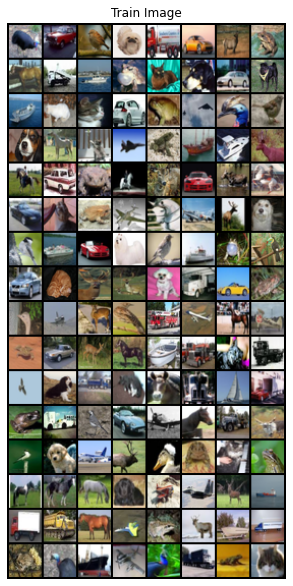

In [60]:
#CIFAR 10에는 다음과 같은 그림이 들어있습니다.
#총 10개의 class
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [61]:
images.shape # 각 image의 size는 32*32이며, batch size = 128, channel = 3(color)입니다.

torch.Size([128, 3, 32, 32])

## 이번에는 직접 모델을 만들어 보도록 하겠습니다.

MNIST 실습파일과는 다르게 정답이 정해지지 않았으며, 오류가 나지 않도록 원하시는 대로 숫자를 넣어 코드를 돌리고 제출해주세요!

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(  # [128, 3, 32, 32]
            nn.Conv2d( 3,16,7),  # 128, 16, 26, 26
            nn.ReLU(),
            nn.MaxPool2d( 2, 2), # 128, 16, 13, 13
            nn.Conv2d( 16, 64, 5), # 128, 64, 8,8
            nn.ReLU(),
            nn.MaxPool2d( 2, 2)#,128, 64, 4, 4
            #nn.Dropout(0.5) 
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64*4*4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1,64*4*4)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [63]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 14.3 Train Model

In [64]:
num_epochs = 30

In [65]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/30], lter [200/390], Loss: 2.2813
Epoch [2/30], lter [200/390], Loss: 2.1589
Epoch [3/30], lter [200/390], Loss: 1.9903
Epoch [4/30], lter [200/390], Loss: 1.9048
Epoch [5/30], lter [200/390], Loss: 1.8553
Epoch [6/30], lter [200/390], Loss: 1.8773
Epoch [7/30], lter [200/390], Loss: 1.6065
Epoch [8/30], lter [200/390], Loss: 1.7489
Epoch [9/30], lter [200/390], Loss: 1.5762
Epoch [10/30], lter [200/390], Loss: 1.5875
Epoch [11/30], lter [200/390], Loss: 1.6074
Epoch [12/30], lter [200/390], Loss: 1.5725
Epoch [13/30], lter [200/390], Loss: 1.5424
Epoch [14/30], lter [200/390], Loss: 1.3338
Epoch [15/30], lter [200/390], Loss: 1.2372
Epoch [16/30], lter [200/390], Loss: 1.3841
Epoch [17/30], lter [200/390], Loss: 1.3406
Epoch [18/30], lter [200/390], Loss: 1.4475
Epoch [19/30], lter [200/390], Loss: 1.5959
Epoch [20/30], lter [200/390], Loss: 1.4380
Epoch [21/30], lter [200/390], Loss: 1.4246
Epoch [22/30], lter [200/390], Loss: 1.2857
Epoch [23/30], lter [200/390], Loss: 1.30

## 14.4 Test Model

In [66]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 56.420000 %


Predicted:    cat  ship   car plane  deer


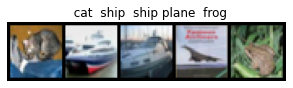

In [68]:
images, labels = iter(test_loader).next()
outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(images, title)